<a href="https://colab.research.google.com/github/aarondelgiudice/thinkful_data_bootcamp/blob/master/unit_7/capstone/7_1f_generate_recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate Recommendations
- Cosine Distance
- Computing Similarity

Now  we have audio features and contextual embeddings for each song. We can use these features to compute the similarity of all our songs and compare the ability of each feature set to return the most similar songs.

For each feature set we'll create a matrix of the cosine distance of each song. We can then use this matrix to find the most similar songs by returning the songs with the shortest distance. We can then compare the ability of each feature set to recommend songs of the greatest similarity.

## Load Data

In [0]:
# load packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

from scipy import spatial

In [0]:
filename = "spotify_lyrics_clean"
df_lyrics = pd.read_csv(filename + ".csv", index_col=0)
df_lyrics.set_index("id", inplace=True)

print(df_lyrics.shape)
print(df_lyrics.dropna().shape)
df_lyrics.head()

(2990, 10)
(2990, 10)


,artist,track,lyrics_raw,length_raw,lyrics_clean,length_clean,lyrics_parsed,length_parsed,lyrics_nostops,length_nostops
id,,,,,,,,,,
7eElVgPcxDqmgGrSwVFI74,lorde,sober,"[Intro]\nNight, midnight, lose my mind\nNight,...",2485,night midnight lose my mind night midnight lo...,2275,"[' ', 'night', 'midnight', 'lose', '-PRON-', '...",494,"[' ', 'night', 'midnight', 'lose', 'mind', 'ni...",187
02oAUzv4M0ItuTDy2RT3IT,lorde,homemade dynamite,[Verse 1]\nA couple rebel top gun pilots\nFlyi...,1795,couple rebel top gun pilots flying with nowhe...,1621,"[' ', 'couple', 'rebel', 'top', 'gun', 'pilot'...",309,"[' ', 'couple', 'rebel', 'gun', 'pilot', 'fly'...",169
5q4BpnMrYEFzLO0dYODj6J,lorde,the louvre,"[Verse 1]\nWell, summer slipped us underneath ...",1824,well summer slipped us underneath her tongue ...,1665,"[' ', 'well', 'summer', 'slip', '-PRON-', 'und...",334,"[' ', 'summer', 'slip', 'underneath', 'tongue'...",151
6Kkt27YmFyIFrcX3QXFi2o,lorde,liability,"[Intro]\nOne, two\n\n[Verse 1]\nBaby really hu...",1305,one two baby really hurt me crying in the tax...,1157,"[' ', 'one', 'two', 'baby', 'really', 'hurt', ...",242,"[' ', 'baby', 'hurt', 'cry', 'taxi', 'don', 'w...",101
1Dp7JGFNjvg8Nk0CtMCcnr,lorde,hard feelings loveless,Hard Feelings\n\n(Go back and tell it)\n\nPlea...,2386,hard feelings go back and tell it please could...,2189,"['hard', 'feeling', 'go', 'back', 'and', 'tell...",458,"['hard', 'feeling', 'tell', 'tender', 'sit', '...",244


In [0]:
filename = "spotify_features"
Audio_features = pd.read_csv(filename + ".csv", index_col=0)

print(Audio_features.shape)
print(Audio_features.dropna().shape)
Audio_features.head()

(2990, 18)
(2990, 18)


,id,target,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence,year
0,7eElVgPcxDqmgGrSwVFI74,0,0.1730,0.796,197236,0.467,True,0.004110,6,0.1260,-10.369,1,59,0.1810,107.901,4,0.516,2017
1,02oAUzv4M0ItuTDy2RT3IT,0,0.2870,0.771,189796,0.431,True,0.000003,10,0.0934,-5.423,1,59,0.0577,107.047,4,0.268,2017
2,5q4BpnMrYEFzLO0dYODj6J,0,0.2390,0.664,271088,0.382,False,0.007490,0,0.0943,-9.977,1,61,0.0470,123.214,4,0.126,2017
3,6Kkt27YmFyIFrcX3QXFi2o,0,0.9200,0.587,171728,0.229,False,0.000000,10,0.1000,-11.254,0,69,0.1280,75.670,4,0.379,2017
4,1Dp7JGFNjvg8Nk0CtMCcnr,0,0.0328,0.487,367391,0.445,True,0.010400,1,0.0778,-10.959,0,60,0.1130,97.031,4,0.180,2017


In [0]:
filename = "spotify_embeddings"
df_emb = pd.read_csv(filename + ".csv", index_col=0)

print(df_emb.shape)
print(df_emb.dropna().shape)
df_emb.head()

(2990, 1024)
(2990, 1024)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7eElVgPcxDqmgGrSwVFI74,-1.176089,-0.107737,-0.569370,-0.250905,-0.196079,0.233768,0.643306,1.164762,-0.953797,0.885341,0.233456,1.157343,-1.184159,2.234673,1.082309,1.509842,1.017656,0.275086,0.189763,0.016859,-0.937232,0.386363,-0.124789,-0.556945,-0.054143,-0.929406,-0.012605,0.002390,0.076078,1.339858,-0.044450,0.330110,0.442595,0.388205,-0.376086,0.700518,0.621598,0.748061,-0.216787,-0.314681,...,0.432884,2.003630,-0.852997,-0.298621,-1.123024,-1.059595,-1.441275,0.095546,2.634760,0.384049,-1.075117,-1.467201,-0.828077,-1.442020,0.099294,0.082079,1.334333,1.647908,-2.649877,0.834402,2.780420,0.148964,-0.253208,-1.001865,3.024287,-0.675499,-0.921162,-0.861756,1.483587,0.678036,0.922910,1.469242,0.220669,-0.197054,1.732071,-2.546426,1.506400,0.784334,3.248197,0.849743
02oAUzv4M0ItuTDy2RT3IT,-0.818456,-0.335162,-0.709084,-0.453882,-0.044109,-0.442736,0.629614,1.860680,-0.421865,1.260538,0.633872,1.731610,-0.870405,1.403824,2.325687,1.376182,0.929350,1.006097,0.436990,-0.342039,-0.436087,0.256072,0.461765,-1.524332,-0.195616,-0.076263,-0.307228,-0.743518,-0.357217,0.622497,0.169596,0.113535,1.616498,0.245950,0.090101,1.020024,0.232876,0.335385,-0.841537,0.021720,...,1.132815,1.599117,1.513349,0.153504,-0.541403,-0.416096,-0.143429,0.899270,2.127211,-0.448340,-0.843154,0.131879,-1.112293,-0.696016,-0.302286,-0.670839,0.732956,1.625931,-1.732838,0.208377,2.225998,0.753254,-0.109293,-1.513544,2.599236,-0.731308,-1.567038,-0.648135,0.277275,-0.293433,-1.702874,1.796735,-0.916728,0.155971,1.281588,-2.694204,1.638449,-0.664250,2.543686,1.326874
5q4BpnMrYEFzLO0dYODj6J,-0.878218,0.282790,-0.808863,-0.433924,0.407604,-0.123266,1.535059,2.379490,-0.050003,1.327469,0.951804,1.565531,-2.178823,2.941031,2.310419,0.691588,0.846726,0.990229,-0.498455,-0.957336,-0.606049,0.509263,-0.357404,-0.061091,-0.657854,0.445772,0.291457,-0.649670,-0.397943,0.907033,0.644040,1.077925,0.929998,-0.379858,-0.019066,1.889962,-0.469290,0.961969,-0.685247,0.497342,...,0.403733,1.477038,-0.157647,-0.359438,-0.464443,-1.103283,-0.482082,-0.203326,2.872298,0.271690,-0.083094,-0.986870,-1.383118,-1.817282,-0.450602,0.486150,1.122400,3.002925,-2.615089,-0.075313,3.189983,0.860678,-1.037161,-0.968324,2.666715,-0.871589,-1.646715,-1.006850,1.233344,1.212906,-0.033491,1.689362,0.355652,-0.423844,1.539076,-1.454237,1.154802,0.642763,3.268840,1.259202
6Kkt27YmFyIFrcX3QXFi2o,-0.466507,0.792432,-0.494447,-0.100590,0.546727,-0.253614,0.794765,2.198832,-0.234965,0.627541,0.867905,1.829224,-1.905063,2.337999,1.501105,0.749387,1.298659,0.994754,-0.205810,-0.534288,-0.753254,0.670505,0.460462,-0.790256,-0.331815,0.215781,-0.252302,-1.027334,-0.459904,1.226175,0.722869,0.377776,0.561733,-0.383966,1.132673,1.598741,-0.868457,0.226428,-0.208647,0.573802,...,0.330872,1.053059,0.763765,-0.465366,-0.088132,-0.982575,-0.554920,-0.862160,1.764676,0.451022,-0.289202,-0.921953,-1.331076,-2.114232,-0.110930,0.491957,0.588337,1.671226,-2.189916,0.884421,2.443677,0.334962,-0.400248,-1.403574,2.521202,-0.352487,-0.814183,-1.534589,0.717943,0.148626,0.648566,1.175033,0.786978,-0.146593,0.475641,-2.374639,0.846798,0.717558,3.282399,1.231623
1Dp7JGFNjvg8Nk0CtMCcnr,-0.821989,1.116456,-0.099389,0.346411,0.864321,-0.394252,0.421176,1.416335,-0.827872,1.231101,0.509105,1.946500,-1.710877,1.770404,1.396535,1.170612,0.788084,1.045131,-0.393810,-0.345053,-0.226228,1.440690,0.052912,-0.692761,-0.927573,-0.514701,-0.332411,-1.399359,-0.215262,1.182957,0.182795,0.323677,0.178181,0.203908,0.652043,1.405541,-0.505214,-0.201571,-0.538093,0.711006,...,0.315548,1.845462,0.990229,-0.891164,-0.580832,-0.711713,0.014514,-0.373449,2.83

In [0]:
filename = "spotify_audio_dist"
Audio_dist = pd.read_csv(filename + ".csv", index_col=0)

print(Audio_dist.shape)
print(Audio_dist.dropna().shape)
Audio_dist.head()

(2990, 2990)
(2990, 2990)


,7eElVgPcxDqmgGrSwVFI74,02oAUzv4M0ItuTDy2RT3IT,5q4BpnMrYEFzLO0dYODj6J,6Kkt27YmFyIFrcX3QXFi2o,1Dp7JGFNjvg8Nk0CtMCcnr,54ucfuN596MU25jQD3KjCL,193Dm5SqYy3hTSbuzxbwKc,6K8VQ84MqhsoakN5MjrnVR,6lFDB0BFDRV58qaQDX85jV,7ARveOiD31w2Nq0n5FsSf8,4fxNwAXn8J9LNi5Rz8eMIv,0cQ5y2ycYOR7KrMG752t8Q,1ZQwftFvuyrHrl41HA9dOC,48jKLs2qqEXKsQTmYHE0JD,2XELtFPg5H2Xmg6eas6dII,2ScrwCtee5LnTrpQZfrxqJ,0j1BAvgZnO5LoRCsGtgYYG,7GLvGlqdg2ocugG4G5ih4I,0cqiehfcVFq3ISC3pO9zLE,7w45f9uLSXE56Bezwjdl8B,53LWnHbfoBuARHoAtEwrBY,3cUQUcDvzrbfSFXHpLvdXf,3fOCHVP6W1uXr2kkZ1dzm0,720VccfW5GV9ZM4OKAAGUg,3t3oNm7M0HXf7ILqA7vCTP,20OrSCxQNhfAtiWtbLn3hf,6mmAeC57zRD5zzVTpB1ACF,3k08Cja0lw4MKJ72AyCGzU,4B6BiC4TZUbvXMbrdx2rhq,0bPSRn4crnh5f1JhELPlyL,7jStM0aMv8WoG91YrrDMbw,5SD3nF4GLH4UTtt0OGWatS,0gb1J5UrTpzaU1s3nupgCd,2MHCiOohBZEQuLgDTPvSzF,46lFttIf5hnUZMGvjK0Wxo,1uf5f99kLdlmUBEvVqrFyy,7kJlTKjNZVT26iwiDUVhRm,401Xo6kdmYwDZ5l0RDsjC4,0LkelFnnzJPC8dtZSZ9Og8,2mSrVZsSKn2Ye5f0YuAbMh,...,3YGsgJqtIWKjMjZtKLk11Z,69gubiWawGe46tKg6DpIyG,1PC5GV3OaoXx5em8ttQOMI,7JtRncm0aTxBotToJC0q5o,3UWdtdvMeFoBQ2UvNUTgGZ,5U51nS2N1TDL1HEHEio7mC,5ZoI4tXPZzcN7PIVmxO7kF,1e6qkPMUiaWZfVk7WdRByQ,6FKasUNG1KT4r9TR9rKdll,2dqkDzJPwSIduZlKJh0lvB,3knwd2whi9QUViKgWCsixF,0OMA1sAHJvRHnBdBLdyOf5,6nS9crd0L3jh2zbGCPGkiC,7FATyApuAis0vzyF86gI4V,2uQfgaV796QLHJCVOP4bn1,1oHdIbwsw3jJvrIKvZdB2e,1TO4RgjyxvQenptaAMqi3w,7x6PA2spm14WxOc4mytj4u,5JoMr0wKviECyfjGX6YO4Y,7KotNh8bE906njI7tnMAME,0NkbSdUKVUTouk8JLh9TjG,2WaxBL2VVPUHqtfQE1yLbF,0E0ZCgyjnMEcPrl46by8tt,05Fqtv0hpBriJj803R6x8i,2DODPLqY24UuvUokVh2JwF,7eG1BnCa7VYmbNM5uMuCRN,2i93Q7j5Pxjsy7PBV2oro2,7aGdHMK2bHKUbsM4cxBi1g,77xNKAq581eD62ipzK81yc,2iVFibcsiZgHivcs9VA08M,4wwyCumdNnXjIGt7YyLCJE,2Qm98Rw4rdfvo14ZOUiZTN,5OKOMO49kNKx3QfJEgNEnF,3eX1QMk3gkVdiBOLeTljwe,4ccdgqrPG8n28V0FWnWWL9,2GyTrOs3AEAjy4MhV4a0kZ,0Gzm4diS5XPuxPFAovPRji,5nI85hC79ERZoEMSreIk4q,1ZcBa2buf2Mx5LHTyOujri,7lpsRa4kcNoxSHUDNDXpnn
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7eElVgPcxDqmgGrSwVFI74,2.220446e-16,0.027732,0.167426,0.310871,0.170524,0.147521,0.201455,0.172309,0.115247,0.144649,0.332983,0.180308,0.155911,0.270753,0.278677,0.277442,0.266867,0.156425,0.139689,0.379401,0.137288,0.212446,0.228635,0.335162,0.236531,0.147753,0.174749,0.226075,0.148696,0.246026,0.150916,0.291462,0.254443,0.145342,0.169950,0.166834,0.138763,0.268863,0.289551,0.052420,...,0.395598,0.425421,0.250000,0.287670,0.322669,0.272515,0.305203,0.226282,0.407442,0.232239,0.292602,0.250466,0.479485,0.297061,0.204069,0.257967,0.393221,0.342593,0.252749,0.373524,0.251582,0.416476,0.290990,0.283563,0.286253,0.343257,0.303329,0.279820,0.382675,0.438665,0.352220,0.466902,0.309975,0.293605,0.257101,0.281641,0.352290,0.397646,0.294267,0.311018
02oAUzv4M0ItuTDy2RT3IT,2.773245e-02,0.000000,0.187155,0.261007,0.199460,0.108363,0.162277,0.194400,0.132999,0.181390,0.376839,0.207112,0.166980,0.314315,0.256778,0.252846,0.290203,0.130155,0.137302,0.363104,0.150874,0.196576,0.233275,0.369651,0.241446,0.103269,0.138453,0.249782,0.170826,0.276460,0.127469,0.271003,0.270202,0.169743,0.197289,0.171052,0.175387,0.267744,0.318651,0.084957,...,0.403943,0.431612,0.288409,0.265822,0.322180,0.292319,0.339562,0.239434,0.406751,0.242012,0.317257,0.230712,0.419644,0.272697,0.223465,0.223408,0.353438,0.346332,0.237028,0.393403,0.303541,0.416337,0.285272,0.261615,0.326876,0.361822,0.311331,0.312380,0.401041,0.439322,0.340242,0.466402,0.348191,0.272347,0.287778,0.338745,0.346523,0.388072,0.266581,0.354963
5q4BpnMrYEFzLO0dYODj6J,1.674263e-01,0.187155,0.000000,0.344304,0.318056,0.374490,0.136380,0.004096,0.199151,0.305742,0.258501,0.049203,0.066871,0.225487,0.360225,0.268174,0.282574,0.095679,0.158644,0.238043,0.085924,0.097716,0.061453,0.281587,0.112164,0.139423,0.145549,0.107370,0.045470,0.261502,0.092120,0.372309,0.268800,0.088980,0.048589,0.167230,0.306989,0.224415,0.259275,0.204575,...,0.409989,0.413274,0.184946,0.266156,0.183073,0.135275,0.218066,0.233729,0.400250,0.181207,0.261174,0.212366,0.482700,0.257760,0.196959,0.209043,0.396654,0.200871,0.251070,0.49197

In [0]:
filename = "spotify_emb_dist"
df_emb_dist = pd.read_csv(filename + ".csv", index_col=0)

print(df_emb_dist.shape)
print(df_emb_dist.dropna().shape)
df_emb_dist.head()

(2990, 2990)
(2990, 2990)


,7eElVgPcxDqmgGrSwVFI74,02oAUzv4M0ItuTDy2RT3IT,5q4BpnMrYEFzLO0dYODj6J,6Kkt27YmFyIFrcX3QXFi2o,1Dp7JGFNjvg8Nk0CtMCcnr,54ucfuN596MU25jQD3KjCL,193Dm5SqYy3hTSbuzxbwKc,6K8VQ84MqhsoakN5MjrnVR,6lFDB0BFDRV58qaQDX85jV,7ARveOiD31w2Nq0n5FsSf8,4fxNwAXn8J9LNi5Rz8eMIv,0cQ5y2ycYOR7KrMG752t8Q,1ZQwftFvuyrHrl41HA9dOC,48jKLs2qqEXKsQTmYHE0JD,2XELtFPg5H2Xmg6eas6dII,2ScrwCtee5LnTrpQZfrxqJ,0j1BAvgZnO5LoRCsGtgYYG,7GLvGlqdg2ocugG4G5ih4I,0cqiehfcVFq3ISC3pO9zLE,7w45f9uLSXE56Bezwjdl8B,53LWnHbfoBuARHoAtEwrBY,3cUQUcDvzrbfSFXHpLvdXf,3fOCHVP6W1uXr2kkZ1dzm0,720VccfW5GV9ZM4OKAAGUg,3t3oNm7M0HXf7ILqA7vCTP,20OrSCxQNhfAtiWtbLn3hf,6mmAeC57zRD5zzVTpB1ACF,3k08Cja0lw4MKJ72AyCGzU,4B6BiC4TZUbvXMbrdx2rhq,0bPSRn4crnh5f1JhELPlyL,7jStM0aMv8WoG91YrrDMbw,5SD3nF4GLH4UTtt0OGWatS,0gb1J5UrTpzaU1s3nupgCd,2MHCiOohBZEQuLgDTPvSzF,46lFttIf5hnUZMGvjK0Wxo,1uf5f99kLdlmUBEvVqrFyy,7kJlTKjNZVT26iwiDUVhRm,401Xo6kdmYwDZ5l0RDsjC4,0LkelFnnzJPC8dtZSZ9Og8,2mSrVZsSKn2Ye5f0YuAbMh,...,69gubiWawGe46tKg6DpIyG,1PC5GV3OaoXx5em8ttQOMI,7JtRncm0aTxBotToJC0q5o,3UWdtdvMeFoBQ2UvNUTgGZ,5U51nS2N1TDL1HEHEio7mC,5ZoI4tXPZzcN7PIVmxO7kF,1e6qkPMUiaWZfVk7WdRByQ,6FKasUNG1KT4r9TR9rKdll,5mCuc8RrujOdKaqQ5dH9so,3knwd2whi9QUViKgWCsixF,4yNZFnV0r7OIuUSep8hFLB,6nS9crd0L3jh2zbGCPGkiC,7FATyApuAis0vzyF86gI4V,7ctM0OVDcGVGN3ciiIbNwu,1oHdIbwsw3jJvrIKvZdB2e,1TO4RgjyxvQenptaAMqi3w,7x6PA2spm14WxOc4mytj4u,5JoMr0wKviECyfjGX6YO4Y,7dcSlYacFNyZThu97HdZLZ,0NkbSdUKVUTouk8JLh9TjG,2WaxBL2VVPUHqtfQE1yLbF,2REeTHmiO6kbkNTwkolGwC,05Fqtv0hpBriJj803R6x8i,2DODPLqY24UuvUokVh2JwF,7eG1BnCa7VYmbNM5uMuCRN,2i93Q7j5Pxjsy7PBV2oro2,7aGdHMK2bHKUbsM4cxBi1g,77xNKAq581eD62ipzK81yc,2iVFibcsiZgHivcs9VA08M,4wwyCumdNnXjIGt7YyLCJE,2Qm98Rw4rdfvo14ZOUiZTN,5OKOMO49kNKx3QfJEgNEnF,3eX1QMk3gkVdiBOLeTljwe,4ccdgqrPG8n28V0FWnWWL9,2GyTrOs3AEAjy4MhV4a0kZ,0Gzm4diS5XPuxPFAovPRji,5nI85hC79ERZoEMSreIk4q,1ZcBa2buf2Mx5LHTyOujri,7lpsRa4kcNoxSHUDNDXpnn,2o3h9YnZHM6T4kzwwLNnHg
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7eElVgPcxDqmgGrSwVFI74,0.000000,1.832921e-01,1.405105e-01,0.159163,1.986258e-01,0.171246,0.162992,0.180567,0.196259,0.164590,0.176466,0.164953,0.195468,0.207626,0.236430,0.205014,0.207998,0.180115,0.174896,0.166141,0.165976,0.155349,0.186268,0.155759,0.154577,0.203824,0.243468,0.204443,0.213898,0.198301,0.222883,0.219082,0.221433,0.196173,0.190695,0.173126,0.181103,0.178971,0.185292,0.185900,...,0.406164,0.386150,0.397790,0.391251,0.372387,0.424729,0.438102,0.488162,0.414092,0.425173,0.438270,0.512475,0.488230,0.412741,0.397636,0.403087,0.464913,0.390948,0.431401,0.470067,0.531009,0.465422,0.468465,0.468551,0.477481,0.537546,0.455475,0.481433,0.474245,0.453171,0.437454,0.506820,0.499112,0.534744,0.492441,0.478872,0.496720,0.501256,0.511471,0.663804
02oAUzv4M0ItuTDy2RT3IT,0.183292,2.220446e-16,1.782953e-01,0.172386,1.835083e-01,0.196291,0.274302,0.269140,0.257346,0.230444,0.223943,0.222609,0.199239,0.220358,0.248595,0.241915,0.159910,0.214282,0.211359,0.197403,0.204863,0.183928,0.177027,0.214001,0.217559,0.229458,0.247304,0.253783,0.219425,0.276898,0.278709,0.241722,0.267301,0.241291,0.212450,0.195792,0.247342,0.240374,0.197473,0.221907,...,0.443286,0.445998,0.500611,0.439653,0.444931,0.468289,0.441597,0.514529,0.440360,0.459071,0.460348,0.530689,0.487139,0.390487,0.435156,0.423211,0.467720,0.449394,0.433547,0.460592,0.487268,0.479931,0.510067,0.521611,0.523009,0.546986,0.505314,0.527788,0.482593,0.501235,0.465238,0.479381,0.499372,0.552965,0.527306,0.500787,0.534514,0.477554,0.518294,0.648093
5q4BpnMrYEFzLO0dYODj6J,0.140510,1.782953e-01,1.110223e-16,0.087217,1.552837e-01,0.095251,0.121515,0.124882,0.189131,0.165355,0.152184,0.126560,0.135353,0.151360,0.196603,0.146437,0.167847,0.146557,0.139034,0.154421,0.160412,0.147647,0.134143,0.105727,0.116984,0.148828,0.195958,0.142646,0.156115,0.155455,0.195164,0.178382,0.186710,0.162833,0.162794,0.157937,0.130386,0.131279,0.156854,0.158548,...,0.347153,0.351705,0.381093,0.338624,0.377857,0.368821,0.372773,0.459290,0.356983,0.409344,0.404142,0.483429,0.417341,0.363552,0.347274,0.353545,0.401957,0

## Cosine Distance

### Audio Features

In [0]:
Data_audio = Audio_features.drop(["id", "explicit", "year"], axis=1)
Data_audio_raw = Data_audio.copy()

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Data_audio = scaler.fit_transform(Data_audio)
Data_audio = pd.DataFrame(Data_audio, columns=Data_audio_raw.columns.values)

Data_audio["explicit"] = Audio_features["explicit"]
Data_audio["explicit"] = np.where(Data_audio["explicit"]==True, 1, 0)

Data_audio.set_index(Audio_features["id"], inplace=True)

display(Data_audio.describe())
Data_audio.head()

,target,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence,explicit
count,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000
mean,0.485284,0.286470,0.541853,0.304413,0.618004,0.078404,0.480207,0.164700,0.741852,0.704348,0.378416,0.072383,0.459464,0.737375,0.434673,0.066555
std,0.499867,0.289535,0.145673,0.109314,0.205458,0.218966,0.327249,0.142005,0.128189,0.456412,0.257976,0.118630,0.182485,0.070155,0.248705,0.249292
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.036509,0.453220,0.235203,0.473857,0.000000,0.181818,0.084051,0.673867,0.000000,0.130952,0.018054,0.318799,0.750000,0.237315,0.000000
50%,0.000000,0.176048,0.546780,0.283736,0.643671,0.000021,0.454545,0.108644,0.768618,1.000000,0.404762,0.033501,0.455024,0.750000,0.415380,0.000000
75%,1.000000,0.485910,0.636695,0.348560,0.788429,0.004865,0.818182,0.194770,0.832345,1.000000,0.571429,0.069809,0.579834,0.750000,0.620496,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,target,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence,explicit
id,,,,,,,,,,,,,,,,
7eElVgPcxDqmgGrSwVFI74,0.0,0.174036,0.817740,0.235386,0.466518,0.004268,0.545455,0.115907,0.636934,1.0,0.702381,0.317954,0.368060,0.75,0.510453,1
02oAUzv4M0ItuTDy2RT3IT,0.0,0.288725,0.787363,0.220164,0.430075,0.000003,0.909091,0.082079,0.823716,1.0,0.702381,0.070612,0.362749,0.75,0.249921,1
5q4BpnMrYEFzLO0dYODj6J,0.0,0.240435,0.657351,0.386488,0.380473,0.007778,0.000000,0.083013,0.651737,1.0,0.726190,0.049147,0.463292,0.75,0.100746,0
6Kkt27YmFyIFrcX3QXFi2o,0.0,0.925553,0.563791,0.183197,0.225591,0.000000,0.909091,0.088928,0.603512,0.0,0.821429,0.211635,0.167615,0.75,0.366530,0
1Dp7JGFNjvg8Nk0CtMCcnr,0.0,0.032988,0.442284,0.583524,0.444248,0.010800,0.090909,0.065892,0.614653,0.0,0.714286,0.181545,0.300460,0.75,0.157475,1


In [0]:
#from scipy import spatial
print(spatial.distance.cosine(Data_audio.iloc[0, :], Data_audio.iloc[1, :]))
print(spatial.distance.cosine(Data_audio.iloc[0, :], Data_audio.iloc[2, :]))

0.027732453239257437
0.1674262699047494


In [0]:
# Compute the similarity matrix between the embeddings vectors.
Audio_dist = spatial.distance.cdist(Data_audio, Data_audio, metric='cosine') 
Audio_dist = pd.DataFrame(data=Audio_dist, columns=Data_audio.index, index=Data_audio.index)

print(Audio_dist.shape)
print(Audio_dist.dropna().shape)
Audio_dist.head()

(2990, 2990)
(2990, 2990)


id,7eElVgPcxDqmgGrSwVFI74,02oAUzv4M0ItuTDy2RT3IT,5q4BpnMrYEFzLO0dYODj6J,6Kkt27YmFyIFrcX3QXFi2o,1Dp7JGFNjvg8Nk0CtMCcnr,54ucfuN596MU25jQD3KjCL,193Dm5SqYy3hTSbuzxbwKc,6K8VQ84MqhsoakN5MjrnVR,6lFDB0BFDRV58qaQDX85jV,7ARveOiD31w2Nq0n5FsSf8,4fxNwAXn8J9LNi5Rz8eMIv,0cQ5y2ycYOR7KrMG752t8Q,1ZQwftFvuyrHrl41HA9dOC,48jKLs2qqEXKsQTmYHE0JD,2XELtFPg5H2Xmg6eas6dII,2ScrwCtee5LnTrpQZfrxqJ,0j1BAvgZnO5LoRCsGtgYYG,7GLvGlqdg2ocugG4G5ih4I,0cqiehfcVFq3ISC3pO9zLE,7w45f9uLSXE56Bezwjdl8B,53LWnHbfoBuARHoAtEwrBY,3cUQUcDvzrbfSFXHpLvdXf,3fOCHVP6W1uXr2kkZ1dzm0,720VccfW5GV9ZM4OKAAGUg,3t3oNm7M0HXf7ILqA7vCTP,20OrSCxQNhfAtiWtbLn3hf,6mmAeC57zRD5zzVTpB1ACF,3k08Cja0lw4MKJ72AyCGzU,4B6BiC4TZUbvXMbrdx2rhq,0bPSRn4crnh5f1JhELPlyL,7jStM0aMv8WoG91YrrDMbw,5SD3nF4GLH4UTtt0OGWatS,0gb1J5UrTpzaU1s3nupgCd,2MHCiOohBZEQuLgDTPvSzF,46lFttIf5hnUZMGvjK0Wxo,1uf5f99kLdlmUBEvVqrFyy,7kJlTKjNZVT26iwiDUVhRm,401Xo6kdmYwDZ5l0RDsjC4,0LkelFnnzJPC8dtZSZ9Og8,2mSrVZsSKn2Ye5f0YuAbMh,...,3YGsgJqtIWKjMjZtKLk11Z,69gubiWawGe46tKg6DpIyG,1PC5GV3OaoXx5em8ttQOMI,7JtRncm0aTxBotToJC0q5o,3UWdtdvMeFoBQ2UvNUTgGZ,5U51nS2N1TDL1HEHEio7mC,5ZoI4tXPZzcN7PIVmxO7kF,1e6qkPMUiaWZfVk7WdRByQ,6FKasUNG1KT4r9TR9rKdll,2dqkDzJPwSIduZlKJh0lvB,3knwd2whi9QUViKgWCsixF,0OMA1sAHJvRHnBdBLdyOf5,6nS9crd0L3jh2zbGCPGkiC,7FATyApuAis0vzyF86gI4V,2uQfgaV796QLHJCVOP4bn1,1oHdIbwsw3jJvrIKvZdB2e,1TO4RgjyxvQenptaAMqi3w,7x6PA2spm14WxOc4mytj4u,5JoMr0wKviECyfjGX6YO4Y,7KotNh8bE906njI7tnMAME,0NkbSdUKVUTouk8JLh9TjG,2WaxBL2VVPUHqtfQE1yLbF,0E0ZCgyjnMEcPrl46by8tt,05Fqtv0hpBriJj803R6x8i,2DODPLqY24UuvUokVh2JwF,7eG1BnCa7VYmbNM5uMuCRN,2i93Q7j5Pxjsy7PBV2oro2,7aGdHMK2bHKUbsM4cxBi1g,77xNKAq581eD62ipzK81yc,2iVFibcsiZgHivcs9VA08M,4wwyCumdNnXjIGt7YyLCJE,2Qm98Rw4rdfvo14ZOUiZTN,5OKOMO49kNKx3QfJEgNEnF,3eX1QMk3gkVdiBOLeTljwe,4ccdgqrPG8n28V0FWnWWL9,2GyTrOs3AEAjy4MhV4a0kZ,0Gzm4diS5XPuxPFAovPRji,5nI85hC79ERZoEMSreIk4q,1ZcBa2buf2Mx5LHTyOujri,7lpsRa4kcNoxSHUDNDXpnn
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7eElVgPcxDqmgGrSwVFI74,2.220446e-16,0.027732,0.167426,0.310871,0.170524,0.147521,0.201455,0.172309,0.115247,0.144649,0.332983,0.180308,0.155911,0.270753,0.278677,0.277442,0.266867,0.156425,0.139689,0.379401,0.137288,0.212446,0.228635,0.335162,0.236531,0.147753,0.174749,0.226075,0.148696,0.246026,0.150916,0.291462,0.254443,0.145342,0.169950,0.166834,0.138763,0.268863,0.289551,0.052420,...,0.395598,0.425421,0.250000,0.287670,0.322669,0.272515,0.305203,0.226282,0.407442,0.232239,0.292602,0.250466,0.479485,0.297061,0.204069,0.257967,0.393221,0.342593,0.252749,0.373524,0.251582,0.416476,0.290990,0.283563,0.286253,0.343257,0.303329,0.279820,0.382675,0.438665,0.352220,0.466902,0.309975,0.293605,0.257101,0.281641,0.352290,0.397646,0.294267,0.311018
02oAUzv4M0ItuTDy2RT3IT,2.773245e-02,0.000000,0.187155,0.261007,0.199460,0.108363,0.162277,0.194400,0.132999,0.181390,0.376839,0.207112,0.166980,0.314315,0.256778,0.252846,0.290203,0.130155,0.137302,0.363104,0.150874,0.196576,0.233275,0.369651,0.241446,0.103269,0.138453,0.249782,0.170826,0.276460,0.127469,0.271003,0.270202,0.169743,0.197289,0.171052,0.175387,0.267744,0.318651,0.084957,...,0.403943,0.431612,0.288409,0.265822,0.322180,0.292319,0.339562,0.239434,0.406751,0.242012,0.317257,0.230712,0.419644,0.272697,0.223465,0.223408,0.353438,0.346332,0.237028,0.393403,0.303541,0.416337,0.285272,0.261615,0.326876,0.361822,0.311331,0.312380,0.401041,0.439322,0.340242,0.466402,0.348191,0.272347,0.287778,0.338745,0.346523,0.388072,0.266581,0.354963
5q4BpnMrYEFzLO0dYODj6J,1.674263e-01,0.187155,0.000000,0.344304,0.318056,0.374490,0.136380,0.004096,0.199151,0.305742,0.258501,0.049203,0.066871,0.225487,0.360225,0.268174,0.282574,0.095679,0.158644,0.238043,0.085924,0.097716,0.061453,0.281587,0.112164,0.139423,0.145549,0.107370,0.045470,0.261502,0.092120,0.372309,0.268800,0.088980,0.048589,0.167230,0.306989,0.224415,0.259275,0.204575,...,0.409989,0.413274,0.184946,0.266156,0.183073,0.135275,0.218066,0.233729,0.400250,0.181207,0.261174,0.212366,0.482700,0.257760,0.196959,0.209043,0.396654,0.200871,0.251070,0.491

In [0]:
from google.colab import files
filename = "spotify_audio_dist"
Audio_dist.to_csv(filename+".csv")
#files.download(filename+".csv")

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 40806, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

### Embeddings

In [0]:
#from scipy import spatial
print(spatial.distance.cosine(df_emb.iloc[0, :], df_emb.iloc[1, :]))
print(spatial.distance.cosine(df_emb.iloc[0, :], df_emb.iloc[2, :]))

0.18329212354500868
0.140510479249766


In [0]:
# Compute the similarity matrix between the embeddings vectors.
emb_dist = spatial.distance.cdist(df_emb, df_emb, metric='cosine') 
df_emb_dist = pd.DataFrame(data=emb_dist, columns=df_emb.index, index=df_emb.index)

print(df_emb_dist.shape)
print(df_emb_dist.dropna().shape)
display(df_emb_dist.head())

(2990, 2990)
(2990, 2990)


id,7eElVgPcxDqmgGrSwVFI74,02oAUzv4M0ItuTDy2RT3IT,5q4BpnMrYEFzLO0dYODj6J,6Kkt27YmFyIFrcX3QXFi2o,1Dp7JGFNjvg8Nk0CtMCcnr,54ucfuN596MU25jQD3KjCL,193Dm5SqYy3hTSbuzxbwKc,6K8VQ84MqhsoakN5MjrnVR,6lFDB0BFDRV58qaQDX85jV,7ARveOiD31w2Nq0n5FsSf8,4fxNwAXn8J9LNi5Rz8eMIv,0cQ5y2ycYOR7KrMG752t8Q,1ZQwftFvuyrHrl41HA9dOC,48jKLs2qqEXKsQTmYHE0JD,2XELtFPg5H2Xmg6eas6dII,2ScrwCtee5LnTrpQZfrxqJ,0j1BAvgZnO5LoRCsGtgYYG,7GLvGlqdg2ocugG4G5ih4I,0cqiehfcVFq3ISC3pO9zLE,7w45f9uLSXE56Bezwjdl8B,53LWnHbfoBuARHoAtEwrBY,3cUQUcDvzrbfSFXHpLvdXf,3fOCHVP6W1uXr2kkZ1dzm0,720VccfW5GV9ZM4OKAAGUg,3t3oNm7M0HXf7ILqA7vCTP,20OrSCxQNhfAtiWtbLn3hf,6mmAeC57zRD5zzVTpB1ACF,3k08Cja0lw4MKJ72AyCGzU,4B6BiC4TZUbvXMbrdx2rhq,0bPSRn4crnh5f1JhELPlyL,7jStM0aMv8WoG91YrrDMbw,5SD3nF4GLH4UTtt0OGWatS,0gb1J5UrTpzaU1s3nupgCd,2MHCiOohBZEQuLgDTPvSzF,46lFttIf5hnUZMGvjK0Wxo,1uf5f99kLdlmUBEvVqrFyy,7kJlTKjNZVT26iwiDUVhRm,401Xo6kdmYwDZ5l0RDsjC4,0LkelFnnzJPC8dtZSZ9Og8,2mSrVZsSKn2Ye5f0YuAbMh,...,69gubiWawGe46tKg6DpIyG,1PC5GV3OaoXx5em8ttQOMI,7JtRncm0aTxBotToJC0q5o,3UWdtdvMeFoBQ2UvNUTgGZ,5U51nS2N1TDL1HEHEio7mC,5ZoI4tXPZzcN7PIVmxO7kF,1e6qkPMUiaWZfVk7WdRByQ,6FKasUNG1KT4r9TR9rKdll,5mCuc8RrujOdKaqQ5dH9so,3knwd2whi9QUViKgWCsixF,4yNZFnV0r7OIuUSep8hFLB,6nS9crd0L3jh2zbGCPGkiC,7FATyApuAis0vzyF86gI4V,7ctM0OVDcGVGN3ciiIbNwu,1oHdIbwsw3jJvrIKvZdB2e,1TO4RgjyxvQenptaAMqi3w,7x6PA2spm14WxOc4mytj4u,5JoMr0wKviECyfjGX6YO4Y,7dcSlYacFNyZThu97HdZLZ,0NkbSdUKVUTouk8JLh9TjG,2WaxBL2VVPUHqtfQE1yLbF,2REeTHmiO6kbkNTwkolGwC,05Fqtv0hpBriJj803R6x8i,2DODPLqY24UuvUokVh2JwF,7eG1BnCa7VYmbNM5uMuCRN,2i93Q7j5Pxjsy7PBV2oro2,7aGdHMK2bHKUbsM4cxBi1g,77xNKAq581eD62ipzK81yc,2iVFibcsiZgHivcs9VA08M,4wwyCumdNnXjIGt7YyLCJE,2Qm98Rw4rdfvo14ZOUiZTN,5OKOMO49kNKx3QfJEgNEnF,3eX1QMk3gkVdiBOLeTljwe,4ccdgqrPG8n28V0FWnWWL9,2GyTrOs3AEAjy4MhV4a0kZ,0Gzm4diS5XPuxPFAovPRji,5nI85hC79ERZoEMSreIk4q,1ZcBa2buf2Mx5LHTyOujri,7lpsRa4kcNoxSHUDNDXpnn,2o3h9YnZHM6T4kzwwLNnHg
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7eElVgPcxDqmgGrSwVFI74,0.000000,1.832921e-01,1.405105e-01,0.159163,1.986258e-01,0.171246,0.162992,0.180567,0.196259,0.164590,0.176466,0.164953,0.195468,0.207626,0.236430,0.205014,0.207998,0.180115,0.174896,0.166141,0.165976,0.155349,0.186268,0.155759,0.154577,0.203824,0.243468,0.204443,0.213898,0.198301,0.222883,0.219082,0.221433,0.196173,0.190695,0.173126,0.181103,0.178971,0.185292,0.185900,...,0.406164,0.386150,0.397790,0.391251,0.372387,0.424729,0.438102,0.488162,0.414092,0.425173,0.438270,0.512475,0.488230,0.412741,0.397636,0.403087,0.464913,0.390948,0.431401,0.470067,0.531009,0.465422,0.468465,0.468551,0.477481,0.537546,0.455475,0.481433,0.474245,0.453171,0.437454,0.506820,0.499112,0.534744,0.492441,0.478872,0.496720,0.501256,0.511471,0.663804
02oAUzv4M0ItuTDy2RT3IT,0.183292,2.220446e-16,1.782953e-01,0.172386,1.835083e-01,0.196291,0.274302,0.269140,0.257346,0.230444,0.223943,0.222609,0.199239,0.220358,0.248595,0.241915,0.159910,0.214282,0.211359,0.197403,0.204863,0.183928,0.177027,0.214001,0.217559,0.229458,0.247304,0.253783,0.219425,0.276898,0.278709,0.241722,0.267301,0.241291,0.212450,0.195792,0.247342,0.240374,0.197473,0.221907,...,0.443286,0.445998,0.500611,0.439653,0.444931,0.468289,0.441597,0.514529,0.440360,0.459071,0.460348,0.530689,0.487139,0.390487,0.435156,0.423211,0.467720,0.449394,0.433547,0.460592,0.487268,0.479931,0.510067,0.521611,0.523009,0.546986,0.505314,0.527788,0.482593,0.501235,0.465238,0.479381,0.499372,0.552965,0.527306,0.500787,0.534514,0.477554,0.518294,0.648093
5q4BpnMrYEFzLO0dYODj6J,0.140510,1.782953e-01,1.110223e-16,0.087217,1.552837e-01,0.095251,0.121515,0.124882,0.189131,0.165355,0.152184,0.126560,0.135353,0.151360,0.196603,0.146437,0.167847,0.146557,0.139034,0.154421,0.160412,0.147647,0.134143,0.105727,0.116984,0.148828,0.195958,0.142646,0.156115,0.155455,0.195164,0.178382,0.186710,0.162833,0.162794,0.157937,0.130386,0.131279,0.156854,0.158548,...,0.347153,0.351705,0.381093,0.338624,0.377857,0.368821,0.372773,0.459290,0.356983,0.409344,0.404142,0.483429,0.417341,0.363552,0.347274,0.353545,0.401957

In [0]:
#from google.colab import files
filename = "spotify_emb_dist"
df_emb_dist.to_csv(filename+".csv")
#files.download(filename+".csv")

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 57308, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

## Computing Similarity

### Audio Features

Seed Artist: lorde
Seed Track: sober


count    2.990000e+03
mean     2.583323e-01
std      7.863454e-02
min      2.220446e-16
25%      2.126336e-01
50%      2.566486e-01
75%      3.009108e-01
max      6.219638e-01
Name: 7eElVgPcxDqmgGrSwVFI74, dtype: float64

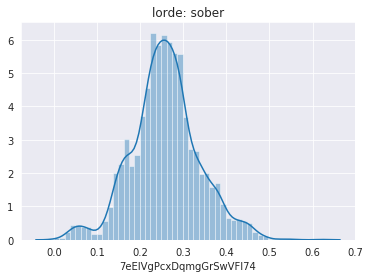

In [0]:
# get ID seed
seed_id = df_lyrics.index[0]
artist = df_lyrics["artist"].loc[seed_id]
track = df_lyrics["track"].loc[seed_id]
print("Seed Artist: {}\nSeed Track: {}".format(artist, track))

display(Audio_dist.loc[:,seed_id].describe())

sns.distplot(Audio_dist.loc[:,seed_id])
plt.title("{}: {}".format(artist, track))
plt.show();

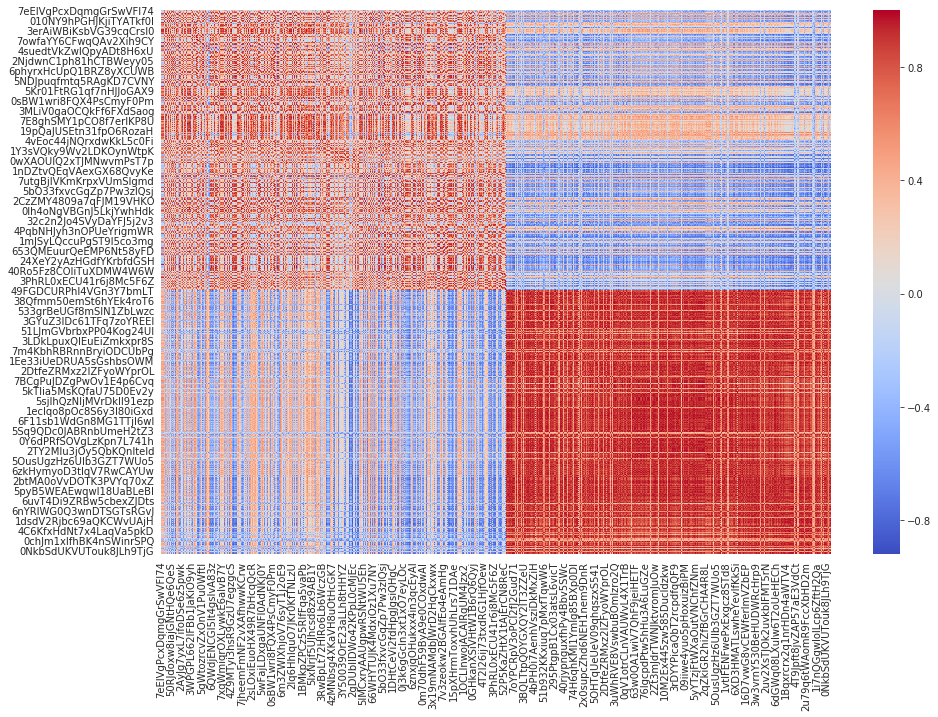

CPU times: user 1min 12s, sys: 1.44 s, total: 1min 14s
Wall time: 1min 13s


In [0]:
%%time
plt.figure(figsize=(15,10))
sns.heatmap(Audio_dist.corr(), cmap='coolwarm')
plt.show();

In [0]:
def get_similar_tracks(seed_id, similarity_df, n=5, similar=True):
  """
  """
  # get artist, track info for seed_id #########################################
  artist = df_lyrics["artist"].loc[seed_id].title()
  track = df_lyrics["track"].loc[seed_id].title()
  print("Seed Artist: {}\nSeed Track: {}".format(artist, track))
  
  if similar==True:
    # get similar IDs ##########################################################
    similar_ids = similarity_df[seed_id].sort_values().index
    
    for idx in similar_ids[:n]: 
      try:
        target = Audio_features["target"].loc[Audio_features["id"]==idx].values
        track = df_lyrics["track"].loc[idx].title()
        artist = df_lyrics["artist"].loc[idx].title()
        print("({}) {} by {}".format(target, track, artist))
      except:
        print("Error: {} not available".format(idx))
  
  else:
    # get least similar IDs ####################################################
    unsimilar_ids = similarity_df[seed_id].sort_values().index
    for idx in unsimilar_ids[-n:]:  
      try:
        target = Audio_features["target"].loc[Audio_features["id"]==idx].values
        track = df_lyrics["track"].loc[idx].title()
        artist = df_lyrics["artist"].loc[idx].title()
        print("({}) {} by {}".format(target, track, artist))
      except:
        print("Error: {} not available".format(idx))

In [0]:
display(get_similar_tracks(seed_id=df_lyrics.index[1], similarity_df=Audio_dist))
get_similar_tracks(df_lyrics.index[1], Audio_dist, similar=False)

Seed Artist: Lorde
Seed Track: Homemade Dynamite
([0]) Homemade Dynamite by Lorde
([0]) Underdressed by Vérité
([0]) Rather Be  by Clean Bandit
([0]) Drinking About You by Ryan Oakes
([0]) Matches by Cash Cash


None

Seed Artist: Lorde
Seed Track: Homemade Dynamite
([0]) Swoon by Daydreamer
([1]) Fix by Chris Lane
Error: 3OlBghpkON2khayltgZlI5 not available
([0]) Desolation Wilderness by Kodak To Graph
Error: 1sTQZqQUchtwYuLZQXw7yS not available
([1]) Loud And Heavy by Cody Jinks
Error: 0LQBbRBsubfHjZbnl2GiGG not available
Error: 6BsaK0v4nm49vNd5ccHyRX not available
([0]) Oculus by Luke Howard
Error: 0j3k6gGcIn3xt1xO7eyLOc not available


### Embeddings

Seed Artist: lorde
Seed Track: sober


count    2990.000000
mean        0.313077
std         0.061631
min         0.000000
25%         0.274621
50%         0.306758
75%         0.342892
max         0.663804
Name: 7eElVgPcxDqmgGrSwVFI74, dtype: float64

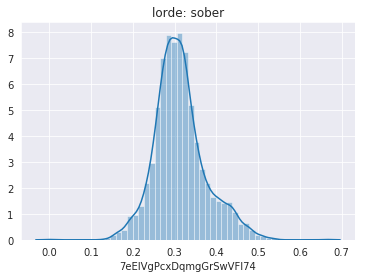

In [0]:
# get ID seed
seed_id = df_lyrics.index[0]
artist = df_lyrics["artist"].loc[seed_id]
track = df_lyrics["track"].loc[seed_id]
print("Seed Artist: {}\nSeed Track: {}".format(artist, track))

display(df_emb_dist.loc[:,seed_id].describe())

sns.distplot(df_emb_dist.loc[:,seed_id])
plt.title("{}: {}".format(artist, track))
plt.show();

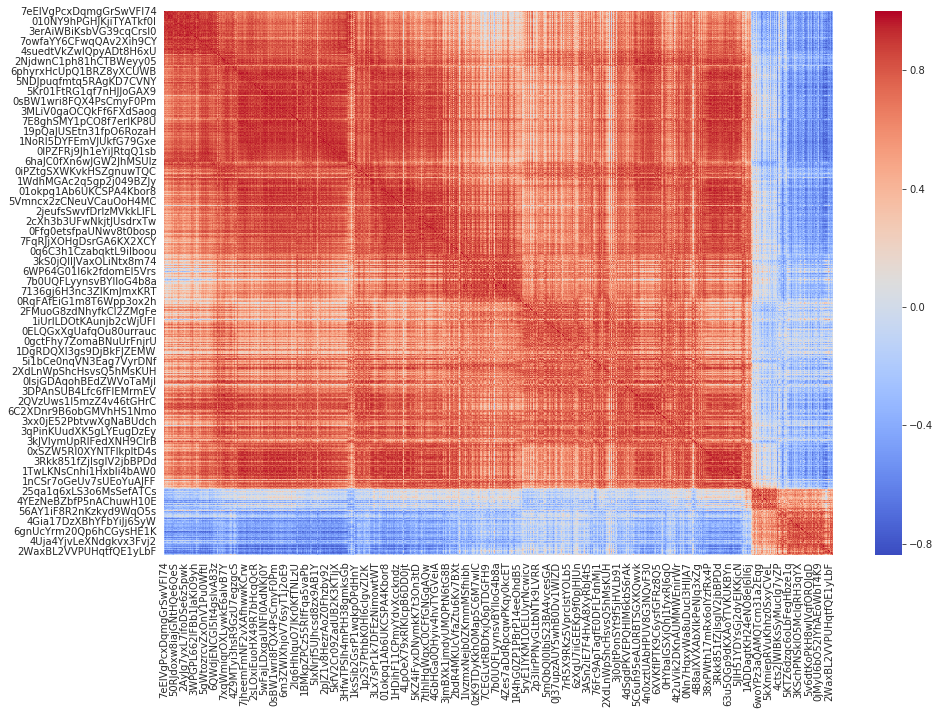

CPU times: user 1min 12s, sys: 1.55 s, total: 1min 14s
Wall time: 1min 13s


In [0]:
%%time
plt.figure(figsize=(15,10))
sns.heatmap(df_emb_dist.corr(), cmap='coolwarm')
plt.show();

In [0]:
display(get_similar_tracks(seed_id=df_lyrics.index[1], similarity_df=df_emb_dist))
get_similar_tracks(df_lyrics.index[1], df_emb_dist, similar=False)

Seed Artist: Lorde
Seed Track: Homemade Dynamite
([0]) Homemade Dynamite by Lorde
([0]) Heavy by Oh Wonder
([0]) Ride Away by Opposite The Other
([0]) Liability by Lorde
([0]) Waste by Oh Wonder


None

Seed Artist: Lorde
Seed Track: Homemade Dynamite
([1]) Kiss An Angel Good Mornin  by Charley Pride
([1]) Most Things Haven T Worked Out by Junior Kimbrough
([1]) If I Never Stop Loving You by David Kersh
([1]) Saint James Infirmary by Snooks Eaglin
([]) I Got My Mojo Working by The Paul Butterfield Blues Band


## Conclusion